# Autoencoder for MNIST in Pytorch Lightning

In this notebook, we will train an autoencoder for the MNIST dataset, which is a datset of handwritten digits. This is the last exercise where we will provide a structured skelleton. For future exercises, we will only provide the dataset, task as well as a test scenario for you to challenge yourself against your peers on our leaderboards.

We will use the PyTorch Lightning framework which makes everything much more convenient! In case you haven't done yet, you should definitely check out the **PyTorch Lightning Introduction** in **Exercise 7**! However, you will mostly design the network architectures as well as be left of to choose suitable hyperparameters for our task at handy, so superficial knowledge of pytorch lightning will suffice.

## What we will do:

One application of autoencoders is unsupervised pretraining with unlabeled data and then finetuning the encoder with labeled data. This can increase our performance if there is only little labeled data but a lot of unlabeled data available.

In this exercise we use the MNIST dataset with 60,000 images of handwirtten digits, but we do not have all the labels available.

We will then train our autoencoder to reproduce the unlabeled images. 

Then we will transfer the pretrained encoder weights and finetune a classifier on the labeled data for classifying the handwritten digits. This is called ***transfer learning***.

**Note**: If you are running this in a google colab notebook, we recommend you enable GPU usage:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies by running the following cell:

In [43]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [44]:
!pip install pytorch-lightning==0.7.6 > /dev/null

# Imports

In [45]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch

from torchvision import transforms
import pytorch_lightning as pl
from exercise_code.image_folder_dataset import ImageFolderDataset
from pytorch_lightning.loggers import TensorBoardLogger
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but, of course, you can also run this notebook on your CPU.
         </p>
</div>

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! Throughout this notebook, feel free to add further logs or visualizations to your TensorBoard!

In [47]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6004

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6004 (pid 15177), started 9:07:00 ago. (Use '!kill 15177' to kill it.)

# Task: the MNIST Dataset

First, we download our dataset. MNIST is a dataset of 60,000 images depicting handwritten digits. However, as with most datasets, labeling is a costly process and therefore we are left in a pickle.

A good starting point is to label a small subset of your images. You either do this yourself but in this instance we consider the case where you hired another student to do it for you. After writing a labeling tool and some time, you are provided with 300 labeled images of which 100 will be used for training, 100 for validation, and 100 for testing. A problematic small number...

Feel free to define some transforms now or later (you can also pass without any transforms).

In [48]:
########################################################################
# TODO: Feel free to define transforms                                 #
########################################################################

pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
mnist_root = os.path.join(i2dl_exercises_path, "datasets", "mnist")

train = ImageFolderDataset(root=mnist_root,images='train_images.pt',labels='train_labels.pt',force_download=False,verbose=True)#,transform=transform)
val = ImageFolderDataset(root=mnist_root,images='val_images.pt',labels='val_labels.pt',force_download=False,verbose=True)#,transform=transform)
test = ImageFolderDataset(root=mnist_root,images='test_images.pt',labels='test_labels.pt',force_download=False,verbose=True)#,transform=transform)

# We also set up the unlabeled images which we will use later
unlabeled_train = ImageFolderDataset(root=mnist_root,images='unlabeled_train_images.pt',force_download=False,verbose=True)#,transform=transform)
unlabeled_val = ImageFolderDataset(root=mnist_root,images='unlabeled_val_images.pt',force_download=False,verbose=True)#,transform=transform)

Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
 https://vision.in.tum.de/webshare/g/i2dl/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
 https://vision.in.tum.de/webshare/g/i2dl/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
 https://vision.in.tum.de/webshare/g/i2dl/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
 https://vision.in.tum.de/webshare/g/i2dl/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
 https://vision.in.tum.de/webshare/g/i2dl/mnist.zip


The dataset consists of tuples of 28x28 pixel PIL images and a label that is an integer from 0 to 9. 

Let's turn a few of the images into numpy arrays, to look at their shape and visualize them and see
if the labels we paid for are correct.

The shape of our greyscale images:  (28, 28)


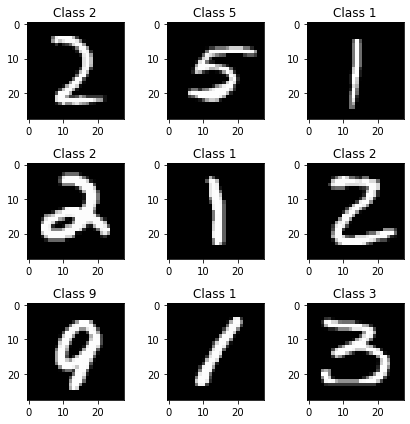

In [49]:
plt.rcParams['figure.figsize'] = (6,6) # Make the figures a bit bigger

for i in range(9):
    image = np.array(train[i][0].squeeze()) # get the image of the data sample
    label = train[i][1] # get the label of the data sample
    plt.subplot(3,3,i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label))
    
plt.tight_layout()
print('The shape of our greyscale images: ', image.shape)


<div class="alert alert-warning">
    <h3>Note: Starting Simple</h3>
    <p>
Regardless of the size of our dataset, the first step we have to take is to evaluate the performance of a simple classifier. Always approach a problems with a simple approach first and go from there to see which changes are helping you.
         </p>
</div>

# A Simple Classifier

In `exercise_code/models.py` we prepared all classes for you which you will finalize throughout the notebook to build an Autoencoder and an image classifier with PyTorch Lightning. If you are unfamiliar with pytorch lightning, you can check out the notebook from the last exercise.

![network_split](img/network_split.png)

### 1. The Encoder

Different to previous models, we are going to split up our model into two parts: the so called `encoder` and the `classifier`. The `classifier` has a static task as it will output our predictions given a one-dimensional input. The `encoder`'s task is to extract meaningful information out of our input so that the classifier can make a proper decision. Right now however, both networks will be consisting of linear layers coupled with auxiliary ones and therefore won't be too different in their design. This split up will be relevant later, e.g., by using convolutional layers which are introduced in the lecture. We are going to set up the `encoder` now. 

Think about a good network architecture. You're completely free here and can come up with any network you like! (\*)

Have a look at the documentation of `torch.nn` at https://pytorch.org/docs/stable/nn.html to learn how to use this module to build your network!

Then implement your architecture: initialize it in `__init__()` and assign it to `self.model`. This is particularly easy using `nn.Sequential()` which you only have to pass the list of your layers. 

To make your model customizable and support parameter search, don't use hardcoded hyperparameters - instead, pass them as dictionary `hparams` (here, `n_hidden` is the number of neurons in the hidden layer) when initializing `models`.

Here's an easy example:

```python
        self.model = nn.Sequential(
            nn.Linear(input_size, self.hparams["n_hidden"]),
            nn.ReLU(),            
            nn.Linear(self.hparams["n_hidden"], num_classes)
        )
```

Have a look at the forward path in `forward(self, x)`, which is so easy, that you don't need to implement it yourself.

As PyTorch automatically computes the gradients, that's all we need to do! No need anymore to manually calculate derivatives for the backward paths! :)


____
\* *The size of your final model must be less than 20 MB, which is approximately equivalent to 5 Mio. params. Note that this limit is quite lenient, you will probably need much less parameters!*

*In order to have a simpler time later on in the notebook, you should only use fully connected layers for this task as we need to revert the encoder architecture*

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Encoder</code> class initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

### 2. The Classifier

Now we are implementing our classifier. It will use the encoder network that you defined in the above cell. By looking at `Classifier.forward`, you can see that we are simply chaining the `classifier` as well as the `encoder` together. Therefore, you have to match the input shape of the classifier to the output shape of your encoder implemented above. 

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Classifier</code> class network initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

### 2. Training & Validation Step

In pytorch lightning, you only have to provide a training and validation step. We implemented those for you, but please check them out so that you understand them.


<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Have a look at the functions <code>training_step</code> and <code>validation_step</code> of the <code>Classifier</code> class in <code>exercise_code/models.py</code>, that take a batch as input and calculate the loss. 
 </p>
</div>

### 3. Optimizer
Lastly, implement the function `configure_optimizers()` to define your optimizer. Here the documentation of `torch.optim`at https://pytorch.org/docs/stable/optim.html might be helpful.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>configure_optimizers</code> method of the <code>Classifier</code> in <code>exercise_code/models.py</code>.
    </p>
</div>



In [50]:
from exercise_code.models import Encoder
from exercise_code.models import Classifier

########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################

hparams = {
    "n_hidden1": 256,
    "n_hidden2": 128,
    "n_hidden3" : 64,
    "num_classes" : 10,
    "learning_rate" : 2e-3,
    "batch_size" : 4
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

encoder = Encoder(hparams)
classifier = Classifier(hparams, encoder, train, val, test)

## Fit Classification Model with Trainer
Now it's time to train your model.

Have a look of the documentation of `pl.Trainer` at https://pytorch-lightning.readthedocs.io/en/latest/trainer.html to find out what arguments you can pass to define your training process.

Then, start the training with `trainer.fit(classifier)` and have a look at the loss and the training accuracy in tensorboard.

In [51]:
import copy
trainer = None

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(classifier) # train the standard classifier
print("Validation accuracy when training from scratch: {}%".format(classifier.getAcc(classifier.val_dataloader())[1]*100))

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name              | Type       | Params
---------------------------------------------
0 | encoder           | Encoder    | 233 K 
1 | encoder.encoder   | Sequential | 233 K 
2 | encoder.encoder.0 | Linear     | 200 K 
3 | encoder.encoder.1 | ReLU       | 0     
4 | encoder.encoder.2 | Linear     | 32 K  
5 | model             | Sequential | 8 K   
6 | model.0           | Linear     | 8 K   
7 | model.1           | ReLU       | 0     
8 | model.2           | Linear     | 650   


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validation accuracy when training from scratch: 57.99999999999999%


# Autoencoder

One hundred images is not a lot of training data. How could we improve our performance? We have no money left to pay our student
for more labels, and labeling the data ourselves is out of question. Also, a good idea would be to do data augmentation to get the most out of our few labeled instances.

One way to solve this problem is to use our large amount of unlabeled data to do unsupervised pretraining with an autoencoder
and then transfer the weights of our encoder to our classifier.

For each image input to the autoencoder, it just tries to reproduce the same image as output. The autoencoder's difficulty is that it has to go through a low dimensional bottleneck, which we call the `latent space`.
The autoencoder should learn to represent all the input information in the low dimensional latent space; it learns to compress the input distribution.
To make our model learn to reproduce the input, we use the mean squared error loss between our input pixels and the
output pixels. For this loss we do not need any labels!

![autoencoder](img/autoencoder.png)

After this our encoder has learned to extract meaningful information from the inputs. We can transfer its weights
to a classifier architecture and finetune it with our labeled data, i.e., instead of initilizing our encoder randomly we are re-using the weights of our trained encoder from our autoencoder network. This process is called `transfer learning`.

![autoencoder_pretrained](img/pretrained.png)

### Decoder

Before we can train our autoencoder, you have to initialize the your `decoder` architecture. The simplest way is to mirror your encoder archticture which ensure that the `latent space` output of our `encoder` is correctly transformed to our input shape.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Decoder</code> class initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

Now, we can train the full autoencoder consisting of both en- and decoder.

In [14]:
from exercise_code.models import Autoencoder, Encoder, Decoder

########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################

hparams = {
    "n_hidden1": 256,
    "n_hidden2": 128,
    "n_hidden3" : 64,
    "num_classes" : 10,
    "learning_rate" : 2e-3,
    "batch_size" : 4
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################


encoder_pretrained = Encoder(hparams)
encoder = Encoder(hparams)
decoder = Decoder(hparams)
ae_logger = TensorBoardLogger(save_dir='lightning_logs')
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder, unlabeled_train, unlabeled_val, ae_logger)

Some tests to check whether we'll accept your model.

In [15]:
from exercise_code.Util import printModelInfo, load_model
_ = printModelInfo(autoencoder)

FYI: Your model has 0.468 mio. params.
Model accepted!


## Autoencoder Training

Next, we define another trainer to fit our autoencoder. Keep in mind that an epoch here will take much longer since
we are iterating through 5,8600 images instead of just 100.

In [16]:
%time
ae_trainer = None

########################################################################
# TODO: Define your trainer! Don't forget the logger.                  #
########################################################################


pass
ae_trainer = pl.Trainer(
    max_epochs=40,
    gpus=1 if torch.cuda.is_available() else None
)

ae_trainer.fit(autoencoder) 
########################################################################
#                           END OF YOUR CODE                           #
########################################################################

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name              | Type       | Params
---------------------------------------------
0 | encoder           | Encoder    | 233 K 
1 | encoder.encoder   | Sequential | 233 K 
2 | encoder.encoder.0 | Linear     | 200 K 
3 | encoder.encoder.1 | ReLU       | 0     
4 | encoder.encoder.2 | Linear     | 32 K  
5 | decoder           | Decoder    | 234 K 
6 | decoder.decoder   | Sequential | 234 K 
7 | decoder.decoder.0 | Linear     | 33 K  
8 | decoder.decoder.1 | ReLU       | 0     
9 | decoder.decoder.2 | Linear     | 201 K 


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: The metric you returned None must be a Torch.Tensor instance, checkpoint not saved HINT: what is the value of val_loss in validation_end()?
  warnings.warn(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)


Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

ModuleAttributeError: 'Autoencoder' object has no attribute 'getAcc'

In [ ]:
print("Validation accuracy when training from scratch: {}%".format(autoencoder.getAcc(autoencoder.val_dataloader())[1]*100))

Once trained, let's have a look at the reconstructed validation images (If you have not already looked at them in tensorboard).

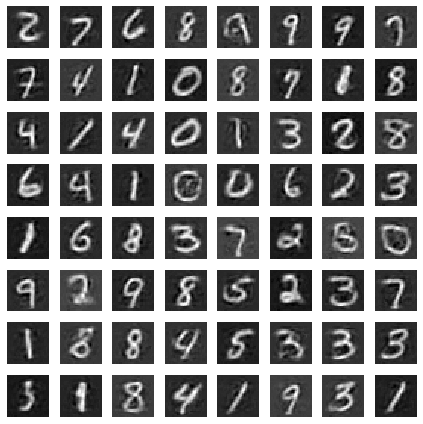

In [17]:
reconstructions = autoencoder.getReconstructions()
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(reconstructions[i], cmap='gray', interpolation='none')
    
plt.tight_layout()

## The pretrained Classifier

Now we initialize another classifier but this time with the pretrained encoder.

In [18]:
from exercise_code.models import Classifier

hparams = {}
########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################

hparams = {
    "n_hidden1": 256,
    "n_hidden2": 128,
    "n_hidden3" : 64,
    "num_classes" : 10,
    "learning_rate" : 2e-3,
    "batch_size" : 4
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
classifier_pretrained = Classifier(hparams, encoder_pretrained, train, val, test)


# Transfer Learning

Now specify another trainer that we will use the pretrained classifier to compare its performance with
the classifier we trained on only the labeled data. You might need to optimize the parameters defined above in order to achieve a reasonable result.

In [19]:
trainer = None

########################################################################
# TODO: Define your trainer! Don't forget the logger.                  #
########################################################################

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else None
)
########################################################################
#                           END OF YOUR CODE                           #
########################################################################
trainer.fit(classifier_pretrained) # train the standard classifier

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name              | Type       | Params
---------------------------------------------
0 | encoder           | Encoder    | 233 K 
1 | encoder.encoder   | Sequential | 233 K 
2 | encoder.encoder.0 | Linear     | 200 K 
3 | encoder.encoder.1 | ReLU       | 0     
4 | encoder.encoder.2 | Linear     | 32 K  
5 | model             | Sequential | 8 K   
6 | model.0           | Linear     | 8 K   
7 | model.1           | ReLU       | 0     
8 | model.2           | Linear     | 650   


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

1

Let's have a look at the validation accuracy of the two different classifiers and compare them. And don't forget that you can also monitor your training in tensorboard.

We will only look at the test accuracy and compare our two classifiers with respect to that in the very end.

In [20]:
print("Validation accuracy when training from scratch: {}%".format(classifier.getAcc(classifier.val_dataloader())[1]*100))
print("Validation accuracy with pretraining: {}%".format(classifier_pretrained.getAcc(classifier.val_dataloader())[1]*100))

Validation accuracy when training from scratch: 59.0%
Validation accuracy with pretraining: 68.0%


Now that everything is working, feel free to play around with different architectures. As you've seen, it's really easy to define your model or do changes there.

To pass this submission, you'll need an accuracy of **55%**.

# Save your model & Report Test Accuracy

When you've done with your **hyperparameter tuning**, have achieved **at least 55% validation accuracy** and are happy with your final model, you can save it here.

Before that, we will check again whether the number of parameters is below 5 Mio and the file size is below 20 MB.

When your final model is saved, we'll lastly report the test accuracy.

In [21]:
from exercise_code.Util import test_and_save

print("Test accuracy when training from scratch: {}%".format(classifier.getAcc()[1]*100))
print('\nNow to the pretrained classifier:')
test_and_save(classifier_pretrained)

Test accuracy when training from scratch: 65.0%

Now to the pretrained classifier:
Validation-Accuracy: 68.0%
FYI: Your model has 0.243 mio. params.
Great! Your model size is less than 20 MB and will be accepted :)
Your model has been saved and is ready to be submitted. NOW, let's check the test-accuracy.
Test-Accuracy: 67.0%


In [22]:
# Now zip the folder for upload
from exercise_code.submit import submit_exercise

submit_exercise('exercise08')

relevant folders: ['exercise_code', 'models']
notebooks files: ['1_Autoencoder_PyTorch_Lightning.ipynb', 'Optional-BatchNormalization&Dropout.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook 1_Autoencoder_PyTorch_Lightning.ipynb
Adding notebook Optional-BatchNormalization&Dropout.ipynb
Zipping successful! Zip is stored under: /Users/husainmustafa/Downloads/MSc-TUM/Winter(2020-21)/I2DL/Exercises/i2dl/exercise_08/exercise08.zip




Congrats! You've now finished your first autoencoder and transferred the weights to a classifier! Much easier than in plain numpy, right? Time to get started with some more complex neural networks and tasks in the upcoming exercises. See you next week!

# Submission Goals

- Goal: Successfully implement a fully connected autoencoder for MNIST with PyTorch Lightning and transfer the encoder weights to a classifier.

- Passing Criteria: There are no unit tests that check specific components of your code. The only thing that's required to pass the submission, is your model to reach at least **55% accuracy** on __our__ test dataset. The submission system will show you a number between 0 and 100 which corresponds to your accuracy.

- Submission start: __Thursday, January 14, 2020 12.00__
- Submission deadline : __Wednesday, January 20, 2020 15.59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus.